In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import time
from datetime import datetime
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import system_comparison_plots
%matplotlib inline


In [20]:
spd_pipeline_one = system_comparison_plots.load_spd_pipeline_one()

In [11]:
ifl_pipeline_one = system_comparison_plots.load_inferline_pipeline_one()

In [21]:
pipeline_one_df = pd.concat([spd_pipeline_one, ifl_pipeline_one])

In [13]:
pipeline_one_df

,CV,cost,lambda,name,slo,slo_miss_rate,slo_plus_25_per_miss_rate,utilization
0,1.0,162.85600,421,SPD-mean_provision,0.35,0.003375,0.000000,NaN
1,1.0,5.08925,104,SPD-mean_provision,0.35,0.000000,0.000000,NaN
2,1.0,76.33875,312,SPD-mean_provision,0.35,0.002869,0.000000,NaN
3,1.0,40.71400,210,SPD-mean_provision,0.35,0.000000,0.000000,NaN
4,1.0,162.85600,307,SPD-peak_provision,0.35,0.001004,0.000481,NaN
5,1.0,5.08925,50,SPD-peak_provision,0.35,0.000000,0.000000,NaN
6,1.0,76.33875,220,SPD-peak_provision,0.35,0.000514,0.000000,NaN
7,1.0,40.71400,131,SPD-peak_provision,0.35,0.000000,0.000000,NaN
8,4.0,162.85600,426,SPD-mean_provision,0.50,0.002526,0.000000,NaN
9,4.0,5.08925,106,SPD-mean_provision,0.50,0.000427,0.000000,NaN


# Plot the results

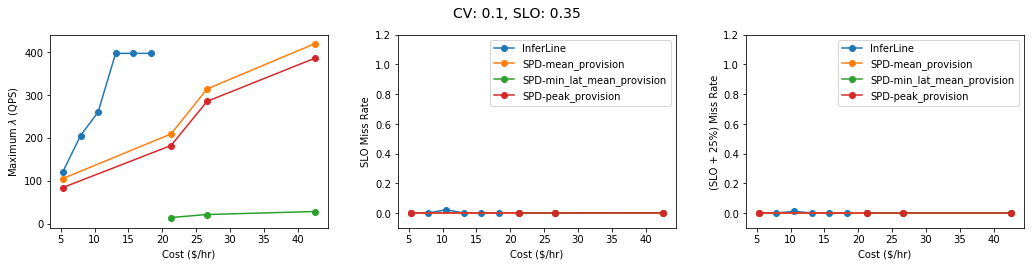

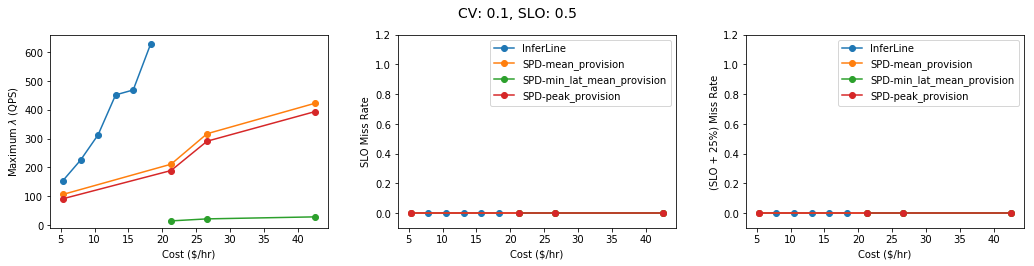

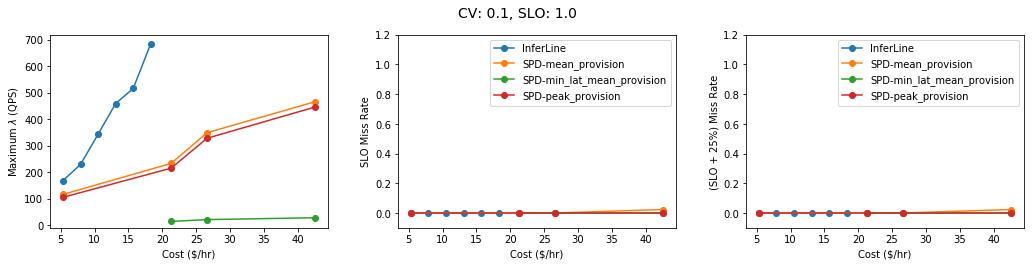

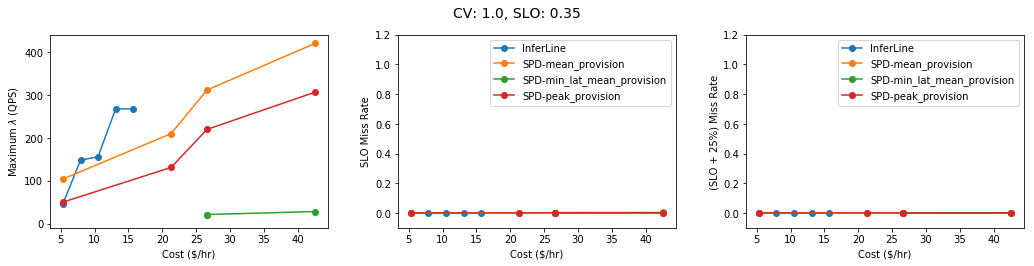

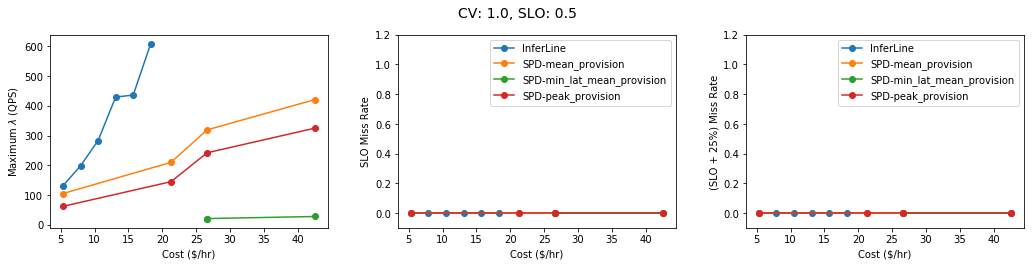

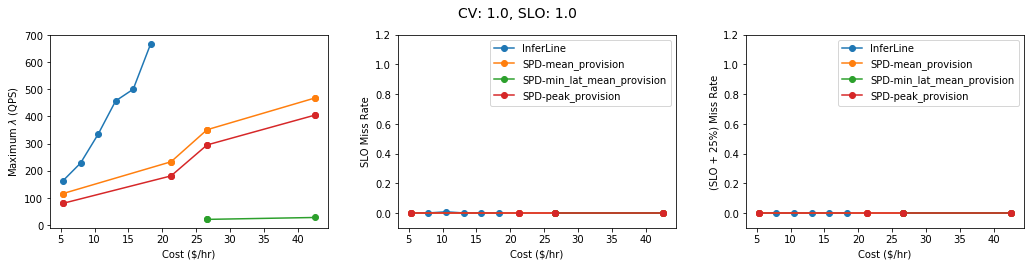

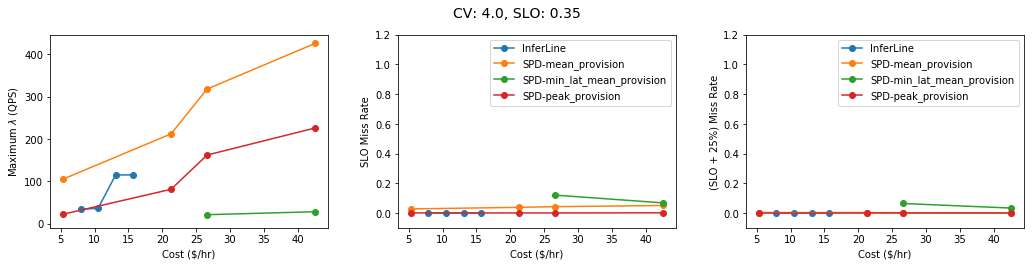

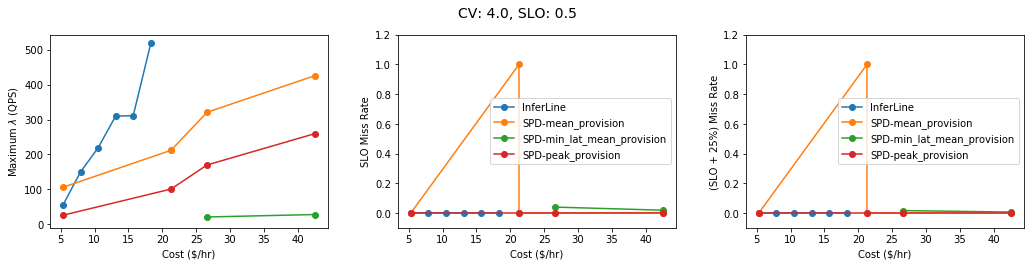

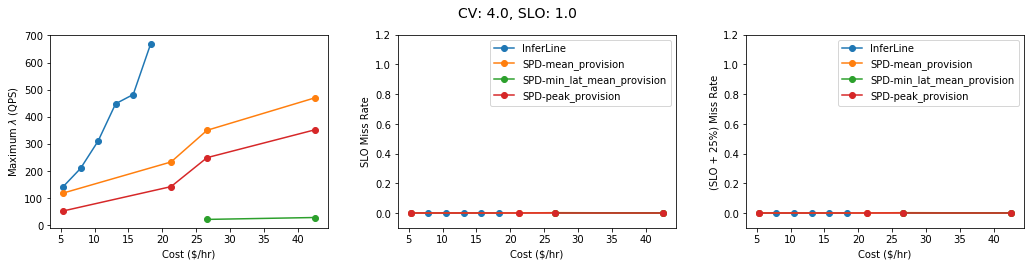

In [25]:

for cv, cv_group in pipeline_one_df.groupby(pipeline_one_df.CV):
    for slo, slo_group in cv_group.groupby(cv_group.slo):
        fig, (ax_lam, ax_slo, ax_slo_25) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
#         fig, (ax_lam, ax_slo) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        for name, name_group in slo_group.groupby(slo_group.name):
            name_group = name_group.sort_values("cost")
            ax_lam.plot(name_group.cost, name_group["lambda"], "o-", label=name)
            ax_slo.plot(name_group.cost, name_group.slo_miss_rate, "o-", label=name)
            ax_slo_25.plot(name_group.cost, name_group.slo_plus_25_per_miss_rate, "o-", label=name)
        ax_lam.set_ylabel("Maximum $\lambda$ (QPS)")
        ax_lam.set_xlabel("Cost ($/hr)")
        ax_lam.set_ylim(bottom=-10)
        ax_slo.set_xlabel("Cost ($/hr)")
        ax_slo.set_ylabel("SLO Miss Rate")
        ax_slo.set_ylim((-.1,1.2))
        ax_slo_25.set_xlabel("Cost ($/hr)")
        ax_slo_25.set_ylabel("(SLO + 25%) Miss Rate")
        ax_slo_25.set_ylim((-.1,1.2))

        ax_slo.legend(loc=0)
        ax_slo_25.legend(loc=0)
        

#         ax_lam.legend(loc=0)
        fig.suptitle("CV: {cv}, SLO: {slo}".format(cv=cv, slo=slo), fontsize=14)
        plt.tight_layout(pad=3)

            
    

In [ ]:
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
for cv, cv_group in df.groupby(df.CV):
    for slo, slo_group in cv_group.groupby(cv_group.slo):
        for name, name_group in slo_group.groupby(slo_group.name):
            ax2.scatter(bytes_per_machine(name_group["cost"], name_group["lambda"]*MB_per_query), name_group["slo_miss_rate"], color="red")
ax2.set_ylabel("SLO Miss Rate")
ax2.set_xlabel("Per-node traffic (MBps)")
fig.suptitle("Effect of contention on SLO miss rate")



Inferline/TensorFlow Serving
Machine A: client -----> machine B: [Clipper ---> model 1, model 2, etc.] 


SPD (old):

Machine B: [SPD replica 1, SPD replica 2]

SPD (new):

machine A: client ---> Machine B: [SPD replica 1, SPD replica 2]


-----------------------------------

Dealing with contention:
1) Same utilization factor for all three systems, tuned for Inferline (utilization == 0.7)
2) Utilization factor but tuned for each system independently
3) Profile inferline models under contention and don't apply utilization factor
